In [1]:
import os
import gzip
import hashlib
import torch
from scipy.special import expit
import torch.nn as nn
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, optim
from tqdm import trange
from torchvision import transforms
from mnist_util import fetch, plot, imshow
np.set_printoptions(suppress=True)

3


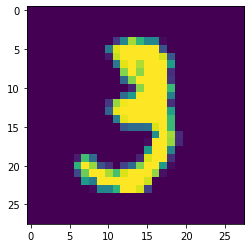

In [2]:
# data starts at offset 16
x_train_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
x_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'

# data starts at index 8
y_train_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
y_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

# download datasets
x_train = fetch(x_train_url)[16:].reshape(-1, 28*28)
y_train = fetch(y_train_url)[8:]

x_test = fetch(x_test_url)[16:].reshape(-1, 28*28)
y_test = fetch(y_test_url)[8:]

# display
i = 10
img = x_train[i]
print(y_train[i])
imshow(img.reshape(28, 28))

In [3]:
# setup
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

Loss: 0.29 Accuracy: 0.92: 100%|██████████| 500/500 [00:01<00:00, 376.53it/s]


finished training


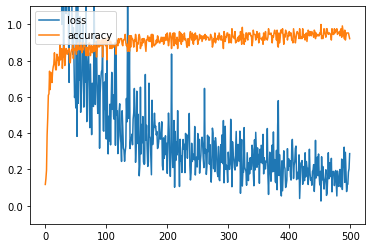

In [4]:
model = Net()

# train
epochs = 500
batch_size = 128
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
losses, accs = [], []
for i in (t := trange(epochs)):
    # batch
    idx = np.random.randint(0, x_train.shape[0], size=(batch_size))
    x = tensor(x_train[idx]).float()
    y = tensor(y_train[idx]).long()
    
    optimizer.zero_grad()
    out = model(x)
    loss = loss_func(out, y)
    loss.backward()
    optimizer.step()

    acc = torch.div(torch.sum(torch.argmax(out, dim=1) == y), batch_size)

    losses.append(loss.detach().numpy())
    accs.append(acc.detach().numpy())
    t.set_description(f'Loss: {loss:.2f} Accuracy: {acc:.2f}')

print('finished training')

plt.ylim(-0.1, 1.1)
plt.plot(losses, label='loss')
plt.plot(accs, label='accuracy')
plt.legend(loc='upper left')
plt.show()

In [5]:
# pytorch eval
y_test_pred = torch.argmax(model(torch.tensor(x_test).float()), dim=1).numpy()
(y_test == y_test_pred).mean()

0.935

In [6]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

# numpy eval
y_test_preds_out = forward(x_test)
y_test_preds = np.argmax(y_test_preds_out, axis=1)
(y_test == y_test_preds).mean()

0.9343

In [7]:
# uncertainty
ret = -y_test_preds_out[range(y_test_preds_out.shape[0]), y_test] + np.log(np.exp(y_test_preds_out).sum())
np.argmax(ret)

2607

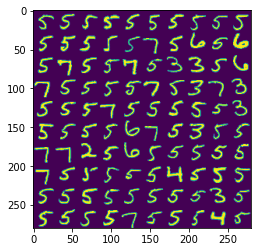

In [8]:
g = 10
grid = x_test[np.argsort(ret)[0:g**2]]
grid = np.concatenate(grid.reshape(g, g*28, 28), axis=1)
imshow(grid)